In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd

data = pd.read_csv("1429_1.csv")

print(data.info())  # Check columns and data types
print(data.head())  # View the first few rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

<ipython-input-2-841dbff637ff>:3: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("1429_1.csv")


In [ ]:
#Data Cleaning
# Step 1: Retain Relevant Columns
relevant_columns = ['reviews.text', 'reviews.rating', 'categories', 'brand', 'name']
data = data[relevant_columns]

In [ ]:
# Step 2: Handle Missing Values
# Drop rows where critical fields (`reviews.text` and `reviews.rating`) are missing
data = data.dropna(subset=['reviews.text', 'reviews.rating'])

In [ ]:
# Step 3: Standardize Text
# Convert text to lowercase and remove special characters and extra spaces
data['reviews.text'] = data['reviews.text'].str.lower()
data['reviews.text'] = data['reviews.text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
data['reviews.text'] = data['reviews.text'].str.strip()

In [ ]:
# Step 4: Deduplicate Entries
# Remove duplicate rows based on all columns
data = data.drop_duplicates()

In [ ]:
# Step 5: Validate Ratings
# Ensure `reviews.rating` contains valid star ratings (e.g., 1-5)
data = data[data['reviews.rating'].isin([1, 2, 3, 4, 5])]

In [ ]:
# Reset the index after cleaning
data = data.reset_index(drop=True)

In [ ]:
# Save the cleaned data to a new CSV file
data.to_csv('cleaned_reviews.csv', index=False)
print("Cleaned dataset saved.")

Cleaned dataset saved.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("cleaned_reviews.csv")

In [ ]:
#Preprocessing for Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE

data = pd.read_csv("cleaned_reviews.csv")

In [ ]:
# Step 1: Address Class Imbalance
# Separate features and target
X = data['reviews.text']
y = data['reviews.rating']

# Map ratings to sentiment categories (positive, neutral, negative)
def map_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

y = y.map(map_sentiment)

# Convert sentiment labels to numeric encoding
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
y = y.map(sentiment_mapping)

In [ ]:
# Step 2: Text Vectorization

# Replace NaN values in 'reviews.text' with an empty string
X = X.fillna("")

# Remove rows where the review text is empty after cleaning
non_empty_indices = X.str.strip() != ""
X = X[non_empty_indices]
y = y[non_empty_indices]


# Use TF-IDF Vectorizer for converting text to numerical features
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(X)

# Save the TF-IDF vectorizer
tfidf_vectorizer_path = "tfidf_vectorizer.pkl"
joblib.dump(tfidf, tfidf_vectorizer_path)
print(f"TF-IDF vectorizer saved to: {tfidf_vectorizer_path}")

TF-IDF vectorizer saved to: tfidf_vectorizer.pkl


In [ ]:
# Step 3: Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

In [ ]:
# Step 4: Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Step 5: Save Preprocessed Data
train_test_data_path = 'preprocessed_train_test_data.pkl'
pd.to_pickle((X_train, X_test, y_train, y_test), train_test_data_path)

print(f"Preprocessed data saved to: {train_test_data_path}")

Preprocessed data saved to: preprocessed_train_test_data.pkl


In [ ]:
#Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = pd.read_pickle(train_test_data_path)

In [ ]:
# Step 1: Train Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Step 2: Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Step 3: Train Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Step 4: Evaluate Models
# Logistic Regression Evaluation
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_logistic))
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))

# Random Forest Evaluation
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Naive Bayes Evaluation
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Report:")
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6545
           1       0.87      0.91      0.89      6410
           2       0.93      0.83      0.87      6420

    accuracy                           0.91     19375
   macro avg       0.91      0.91      0.90     19375
weighted avg       0.91      0.91      0.90     19375

Accuracy: 0.9055483870967742
Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6545
           1       0.98      0.99      0.99      6410
           2       0.99      0.97      0.98      6420

    accuracy                           0.99     19375
   macro avg       0.99      0.99      0.99     19375
weighted avg       0.99      0.99      0.99     19375

Accuracy: 0.9880774193548387
Naive Bayes Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      6545
 

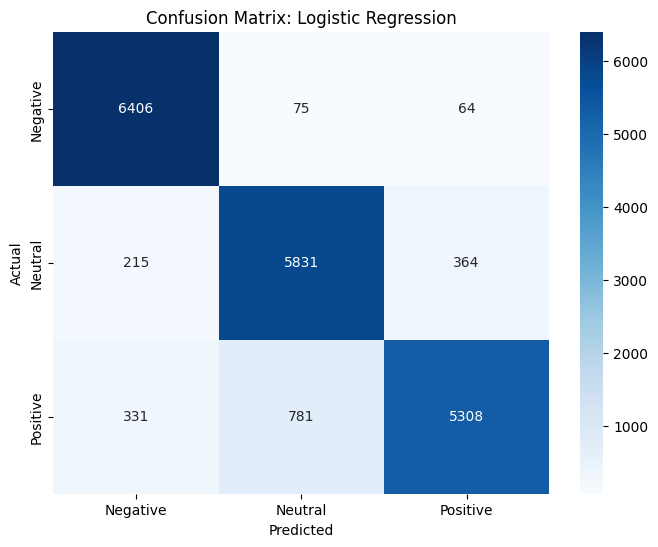

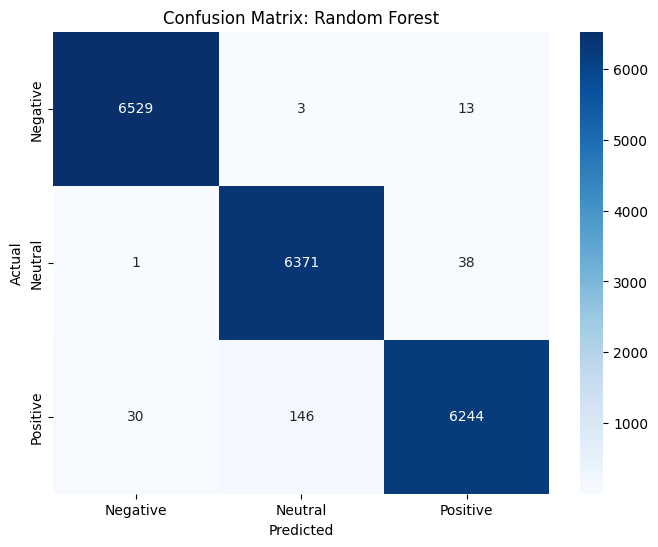

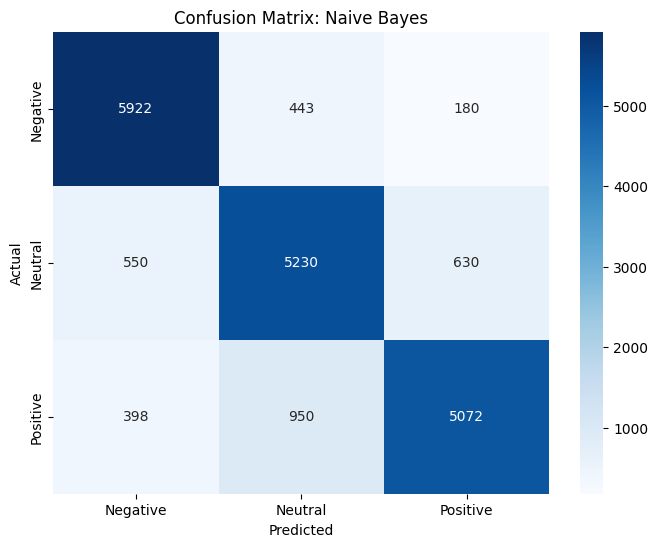

In [ ]:
# Step 5: Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(y_test, y_pred_logistic, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")

In [ ]:
#saving the original
import joblib

# Save the original Random Forest model
model_path = 'original_rf_model.pkl'
joblib.dump(rf_model, model_path)
print(f"Model saved to {model_path}")


Model saved to original_rf_model.pkl


**LSTM**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load cleaned dataset
data = pd.read_csv("cleaned_reviews.csv")

In [ ]:
# Step 1: Load and Preprocess the Dataset
# Map ratings to sentiment categories
def map_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

X = data['reviews.text'].fillna("")
y = data['reviews.rating'].map(map_sentiment).map({'positive': 2, 'neutral': 1, 'negative': 0})

# Remove empty reviews
non_empty_indices = X.str.strip() != ""
X = X[non_empty_indices]
y = y[non_empty_indices]

In [ ]:
# Step 2: Tokenize and Pad Sequences
vocab_size = 10000  # Limit vocabulary size
max_length = 100    # Limit sequence length

# Tokenizer setup
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(X)

# Pad sequences to ensure uniform length
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
# Step 3: Address Class Imbalance with SMOTE
smote = SMOTE(random_state=42)

# SMOTE requires reshaping padded sequences to 2D for processing
X_padded_reshaped = X_padded.reshape(X_padded.shape[0], -1)
X_resampled, y_resampled = smote.fit_resample(X_padded_reshaped, y)

# Reshape back to original padded format
X_resampled = X_resampled.reshape(-1, max_length)

In [ ]:
# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Step 5: Save Preprocessed Data
train_test_data_path = 'preprocessed_train_test_data_lstm.pkl'
pd.to_pickle((X_train, X_test, y_train, y_test), train_test_data_path)

print(f"Preprocessed data saved to: {train_test_data_path}")

Preprocessed data saved to: preprocessed_train_test_data_lstm.pkl


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load Preprocessed Data
train_test_data_path = 'preprocessed_train_test_data_lstm.pkl'
X_train, X_test, y_train, y_test = pd.read_pickle(train_test_data_path)

In [ ]:
# Step 2: Build the LSTM Model
vocab_size = 10000  # Ensure this matches the tokenizer vocab_size
max_length = 100    # Ensure this matches the sequence length used in preprocessing

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: negative, neutral, positive
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 3: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/10
2422/2422 - 61s - 25ms/step - accuracy: 0.5930 - loss: 0.7680 - val_accuracy: 0.6509 - val_loss: 0.6461
Epoch 2/10
2422/2422 - 74s - 30ms/step - accuracy: 0.6658 - loss: 0.5939 - val_accuracy: 0.6860 - val_loss: 0.5914
Epoch 3/10
2422/2422 - 83s - 34ms/step - accuracy: 0.7025 - loss: 0.5398 - val_accuracy: 0.7053 - val_loss: 0.5721
Epoch 4/10
2422/2422 - 82s - 34ms/step - accuracy: 0.7292 - loss: 0.5043 - val_accuracy: 0.6997 - val_loss: 0.5863
Epoch 5/10
2422/2422 - 80s - 33ms/step - accuracy: 0.7463 - loss: 0.4860 - val_accuracy: 0.7172 - val_loss: 0.5852
Epoch 6/10
2422/2422 - 82s - 34ms/step - accuracy: 0.7591 - loss: 0.4661 - val_accuracy: 0.7064 - val_loss: 0.6005


606/606 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.61      0.63      0.62      6545
     Neutral       0.59      0.52      0.55      6410
    Positive       0.89      0.97      0.93      6420

    accuracy                           0.71     19375
   macro avg       0.70      0.71      0.70     19375
weighted avg       0.70      0.71      0.70     19375



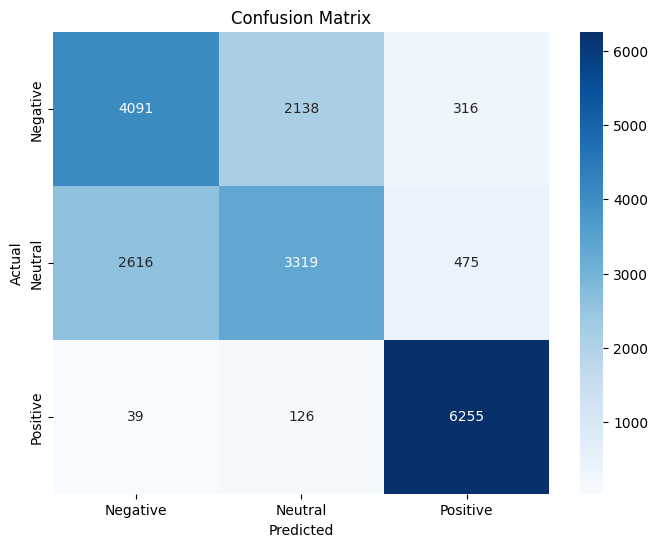

In [ ]:
# Step 4: Evaluate the Model
y_pred = model.predict(X_test).argmax(axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
#attemt of Improve 3
from tensorflow.keras.optimizers import Adam
# Step 1: Load Preprocessed Data
train_test_data_path = 'preprocessed_train_test_data_lstm.pkl'
X_train, X_test, y_train, y_test = pd.read_pickle(train_test_data_path)

# Step 2: Build the Enhanced LSTM Model with Lower Learning Rate
vocab_size = 10000
max_length = 150
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compile with lower learning rate
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(y_train.unique())  # Check the unique labels in training data


[1 2 0]


In [ ]:
# Step 3: Train the Model with Class Weights
class_weights = {0: 2.0, 1: 2.0, 2: 1.0}  # Higher weights for Negative and Neutral classes

# Convert Data to NumPy Arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weights, 
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/10
2422/2422 - 59s - 24ms/step - accuracy: 0.6063 - loss: 1.3008 - val_accuracy: 0.6818 - val_loss: 0.6149
Epoch 2/10
2422/2422 - 80s - 33ms/step - accuracy: 0.7054 - loss: 1.0553 - val_accuracy: 0.7067 - val_loss: 0.5595
Epoch 3/10
2422/2422 - 81s - 33ms/step - accuracy: 0.7353 - loss: 0.9705 - val_accuracy: 0.7116 - val_loss: 0.5559
Epoch 4/10
2422/2422 - 54s - 22ms/step - accuracy: 0.7588 - loss: 0.9116 - val_accuracy: 0.7060 - val_loss: 0.5777
Epoch 5/10
2422/2422 - 81s - 33ms/step - accuracy: 0.7780 - loss: 0.8521 - val_accuracy: 0.7045 - val_loss: 0.5983
Epoch 6/10
2422/2422 - 82s - 34ms/step - accuracy: 0.8012 - loss: 0.7884 - val_accuracy: 0.6954 - val_loss: 0.6276


606/606 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.61      0.64      0.62      6545
     Neutral       0.60      0.54      0.57      6410
    Positive       0.92      0.95      0.93      6420

    accuracy                           0.71     19375
   macro avg       0.71      0.71      0.71     19375
weighted avg       0.71      0.71      0.71     19375



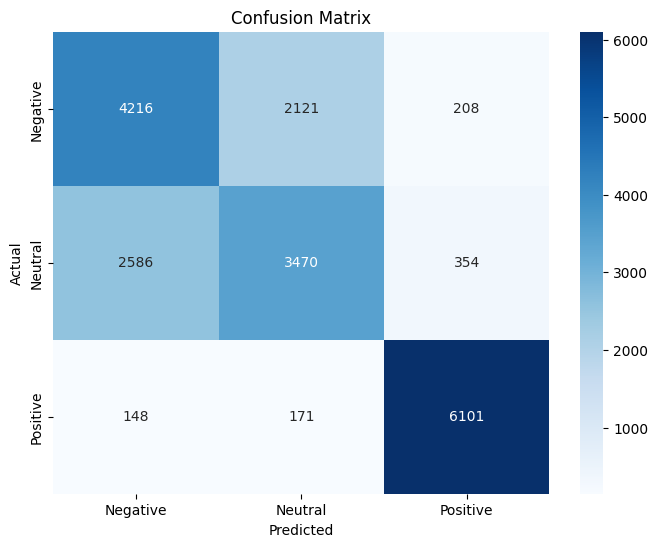

In [ ]:
# Step 4: Evaluate the Model
y_pred = model.predict(X_test).argmax(axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Save the trained model to an HDF5 file
model.save("lstm_sentiment_model.h5")
print("Model saved as lstm_sentiment_model.h5")

Model saved as lstm_sentiment_model.h5


In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


**Transformers**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

# Step 1: Load Preprocessed Data
data_path = "cleaned_reviews.csv"
data = pd.read_csv(data_path)

# Map ratings to sentiment categories
def map_sentiment(rating):
    if rating >= 4:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

data["labels"] = data["reviews.rating"].apply(map_sentiment)
data = data[["reviews.text", "labels"]].dropna()

# Train-test split
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data["reviews.text"].tolist(), data["labels"].tolist(), test_size=0.2, random_state=42
)

# Create a Dataset object
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})



In [ ]:
pd.DataFrame(test_dataset)['text'].values.tolist()[0]

'i ended up buying the echo on sale i was thrilled once alexa was set up which by the way is easy i just bought another one on sale and gave it as a gift a must have for sure if you like technology alexa is helpful and a lot of fun'

In [ ]:
# Step 2: Tokenize the Data
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

encoded_dataset = dataset.map(preprocess_function, batched=True)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/27680 [00:00<?, ? examples/s]

Map:   0%|          | 0/6921 [00:00<?, ? examples/s]

In [ ]:
# Step 3: Load Pre-Trained Transformer Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 4: Fine-Tune the Model
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

# Step 5: Evaluate the Model
metrics = trainer.evaluate()
print(metrics)

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")
print("Model and tokenizer saved to ./fine_tuned_model")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-46f596d4cc12>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.219500,0.171348,0.948707,0.936965,0.948707,0.936563
2,0.085800,0.179755,0.947117,0.935458,0.947117,0.939918
3,0.076400,0.220136,0.945528,0.939484,0.945528,0.941969


{'eval_loss': 0.17134827375411987, 'eval_accuracy': 0.948706834272504, 'eval_precision': 0.9369646436038626, 'eval_recall': 0.948706834272504, 'eval_f1': 0.9365633964099194, 'eval_runtime': 50.5502, 'eval_samples_per_second': 136.913, 'eval_steps_per_second': 8.566, 'epoch': 3.0}
Model and tokenizer saved to ./fine_tuned_model


**Practice for web page**

In [ ]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Load the Random Forest model
model_path = "original_rf_model.pkl"
rf_model = joblib.load(model_path)
print("Random Forest model loaded successfully.")

# Step 2: Load the new CSV file
csv_file = "/content/cleaned_reviews.csv"
data = pd.read_csv(csv_file)

# Assuming the review text is in a column named 'reviews.text'
if 'reviews.text' not in data.columns:
    raise ValueError("The CSV file must have a 'reviews.text' column for the reviews.")

# Step 3: Preprocess the review text
# Load the TF-IDF vectorizer used during training
tfidf_path = "/content/tfidf_vectorizer.pkl"  
tfidf = joblib.load(tfidf_path)
print("TF-IDF vectorizer loaded successfully.")

# Transform the review text into numerical features
X_new = tfidf.transform(data['reviews.text'].fillna(""))

# Step 4: Make Predictions
predictions = rf_model.predict(X_new)

# Step 5: Map predictions back to sentiment labels
sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
predicted_labels = [sentiment_mapping[label] for label in predictions]

# Add the predictions to the original DataFrame
data['Predicted Sentiment'] = predicted_labels

# Display the updated DataFrame
print(data[['reviews.text', 'Predicted Sentiment']])


Random Forest model loaded successfully.
TF-IDF vectorizer loaded successfully.
                                            reviews.text Predicted Sentiment
0      this product so far has not disappointed my ch...            Positive
1      great for beginner or experienced person bough...            Positive
2      inexpensive tablet for him to use and learn on...            Positive
3      ive had my fire hd 8 two weeks now and i love ...            Positive
4      i bought this for my grand daughter when she c...            Positive
...                                                  ...                 ...
34597  this is not appreciably faster than any other ...             Neutral
34598  amazon should include this charger with the ki...            Positive
34599  love my kindle fire but i am really disappoint...            Positive
34600  i was surprised to find it did not come with a...            Positive
34601  to spite the fact that i have nothing but good...            Posit

**Part 2 of Project**

In [ ]:
pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 38.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [ ]:
!pip uninstall -y torch torchvision torchaudio transformers
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Found existing installation: transformers 4.48.1
Uninstalling transformers-4.48.1:
  Successfully uninstalled transformers-4.48.1
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.4/838.4 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 49.9 MB/s eta 0:00:0

  Using cached transformers-4.48.1-py3-none-any.whl.metadata (44 kB)
Using cached transformers-4.48.1-py3-none-any.whl (9.7 MB)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from transformers import pipeline

# Step 1: Load the Dataset
data = pd.read_csv("cleaned_reviews.csv")

# Ensure necessary columns exist
if not {'categories', 'reviews.rating', 'reviews.text'}.issubset(data.columns):
    raise ValueError("The dataset must contain 'categories', 'reviews.rating', and 'reviews.text' columns.")

In [ ]:
# Step 2: Preprocessing
# Fill missing values and filter non-empty reviews
data = data.dropna(subset=['categories', 'reviews.rating', 'reviews.text'])
data = data[data['reviews.text'].str.strip() != ""]

# Convert ratings to integers (if not already)
data['reviews.rating'] = data['reviews.rating'].astype(int)

In [ ]:
# Step 3: Select Top-K Categories
K = 10
top_categories = data['categories'].value_counts().nlargest(K).index
filtered_data = data[data['categories'].isin(top_categories)]

In [ ]:
# Step 4: Group Reviews by Category and Rating
grouped_reviews = filtered_data.groupby(['categories', 'reviews.rating'])['reviews.text'].apply(lambda x: " ".join(x)).reset_index()

In [ ]:
# Step 5: Summarization Using Generative AI
# Load a pre-trained summarization model
summarizer = pipeline("summarization", model="google/flan-t5-base")  # philschmid/flan-t5-base-samsum

# Function to summarize reviews
def summarize_reviews(text, max_length=512):#power of 2
    try:
        return summarizer(text, max_length=max_length, min_length=30, truncation=True)[0]['summary_text']
    except Exception as e:
        return f"Error during summarization: {str(e)}"

# Apply summarization for each category and rating
grouped_reviews['summary'] = grouped_reviews['reviews.text'].apply(lambda x: summarize_reviews(x))

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0
Your max_length is set to 512, but your input_length is only 307. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=153)
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your max_length is set to 512, but your input_length is only 434. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=217)
Your max_length is set to 512, but your input_length is only 353. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=176)
Your max_length is set to 512, but your input_length is only 187. Since this is a summarization task, where outpu

In [ ]:
# Step 6: Save or Display Results
output_file = "summarized_reviews.csv"
grouped_reviews.to_csv(output_file, index=False)
print(f"Summarized reviews saved to {output_file}")

Summarized reviews saved to summarized_reviews.csv


In [ ]:
from transformers import pipeline

# Load the FLAN-T5 summarization model
summarizer = pipeline("summarization", model="google/flan-t5-base")

# Save the model and tokenizer
save_directory = "./flan_t5_summary_model"
summarizer.model.save_pretrained(save_directory)
summarizer.tokenizer.save_pretrained(save_directory)

print(f"Model saved to {save_directory}")

Device set to use cuda:0


Model saved to ./flan_t5_summary_model


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Directory where your model and tokenizer are saved
model_directory = "./flan_t5_summary_model"

# Load the saved tokenizer and model from the specified directory
tokenizer = T5Tokenizer.from_pretrained(model_directory)
model = T5ForConditionalGeneration.from_pretrained(model_directory)

def summarize_review(review_text):
    inputs = tokenizer.encode("summarize: " + review_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example usage:
if __name__ == "__main__":
    review = input("Enter your review: ")
    summary = summarize_review(review)
    print("\nSummary:")
    print(summary)

Enter your review: most buyers will have a phone or other charger that will work so you probably dont need to buy this cheap need to constantly make sure plugged in slightly too small saved some bucks there not amazon quality if you actually paid 20 for this adapter youre out of your mind this is the third power charger that i have had to buy at cost of over 30 each since my kindle fire purchase why cant the chargers last a reasonable amount of time when i connected this charger i received a message saying that it was a low level charger it probably would not charge while the kindle was in use not acceptable for this cost i wish this came in white to match my kindle paperwhite really expected a chord with it for the price we paid very dissapointed not compatible with south african plug standards bought this unnecessarily it wasnt what i thought it was the price was too much for what i got very disappointed i had to buy it what else is there to say 5 dollar ac to usb power adapter for 2